# Market Analyst – Google Trends (Real‑Time) with `pytrends`

This notebook powers the **Market Analyst** agent to fetch near real‑time product interest signals using **Google Trends**. It supports:
- Interest over time for target keywords (e.g., product names, categories)
- Related queries for discovery
- Realtime trending searches (India or by category)
- City/region targeting (e.g., Surat via state filter or DMA where available)
- **Offline mock mode** to generate synthetic data for unit tests

> Output artifacts (CSV/JSON) are saved under `./artifacts/` for downstream agents (Layout Strategist / Draftsman).

## 0) Environment Setup

In [ ]:
# If running on a fresh environment, uncomment the next line
# %pip install pytrends pandas matplotlib plotly --quiet

## 1) Imports & Global Config

In [18]:
from pathlib import Path
import json
from datetime import datetime, timedelta
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import pytrends; if unavailable/offline, we'll rely on MOCK mode
try:
    from pytrends.request import TrendReq
    PYTRENDS_AVAILABLE = True
except Exception:
    PYTRENDS_AVAILABLE = False

# -------- Notebook Configuration --------
# Toggle to True if you want to run without internet (generates synthetic data)
MOCK = False  # set to True to test without external calls

# Default keywords (tune per market)
KEYWORDS = ["iPhone 15", "Samsung Galaxy S24", "noise cancelling headphones", "gaming laptop"]

# Target geography
# For India overall: geo="IN"
# For state-level filtering (e.g., Gujarat): geo="IN-GJ"
GEO = "IN"            # Country
SUB_GEO = "IN-GJ"     # State (Gujarat) to proxy interest for Surat region

# Time window: use 'now 7-d' for last 7 days, or explicit like '2024-01-01 2024-02-01'
TIMEFRAME = "today 3-m"   # 'now 1-H', 'now 4-H', 'now 1-d', 'now 7-d', 'today 3-m', etc.

# Google product (vertical) – 'news', 'images', 'youtube', 'froogle' (Shopping)
GPROP = "froogle"       # focuses on Google Shopping interest

# Output directory
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

print(f"pytrends available: {PYTRENDS_AVAILABLE}")
print(f"MOCK mode: {MOCK}")

pytrends available: True
MOCK mode: False


## 2) Utilities – Mock Data (Offline-Friendly)

In [19]:
def _mock_interest_over_time(keywords, periods=168, freq='H'):
    idx = pd.date_range(end=pd.Timestamp.now().floor('H'), periods=periods, freq=freq)
    data = {}
    for kw in keywords:
        base = random.randint(20, 60)
        noise = pd.Series([random.randint(-5, 5) for _ in range(periods)], index=idx).cumsum()
        season = pd.Series([max(0, int(15*abs(np.sin(i/10)))) for i in range(periods)], index=idx)  # simple synthetic seasonality
        series = pd.Series(base, index=idx) + noise + season
        series = series.clip(lower=0)
        data[kw] = series
    df = pd.DataFrame(data)
    df.index.name = "datetime"
    return df

def _mock_related_queries(keywords):
    mock = {}
    for kw in keywords:
        mock[kw] = {
            "top": pd.DataFrame({
                "query": [f"{kw} price", f"{kw} review", f"{kw} specs", f"best alternative to {kw}"],
                "value": [100, 85, 77, 64]
            }),
            "rising": pd.DataFrame({
                "query": [f"{kw} discount", f"{kw} exchange offer", f"{kw} vs competitor"],
                "value": [800, 540, 420]
            })
        }
    return mock

def _mock_realtime_trends():
    return pd.DataFrame({
        "title": ["Festive sale electronics", "iPhone 16 rumors", "Noise ANC Pro 2", "OLED TV deals"],
        "entity_names": [["sale"], ["iphone"], ["headphones"], ["tv"]],
        "traffic": [100000, 82000, 45000, 39000],
    })

## 3) Initialize Google Trends Client

In [20]:
def make_trends_client():
    if MOCK or not PYTRENDS_AVAILABLE:
        return None
    return TrendReq(hl='en-US', tz=330)  # IST timezone offset (+5:30)

pytrend = make_trends_client()
pytrend

## 4) Interest Over Time – Target Keywords

In [21]:
def fetch_interest_over_time(keywords, geo, timeframe, gprop):
    if MOCK or pytrend is None:
        df = _mock_interest_over_time(keywords, periods=7*24, freq='H')
        df["isPartial"] = False
        return df

    pytrend.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo, gprop=gprop)
    df = pytrend.interest_over_time()
    return df

iot_df = fetch_interest_over_time(KEYWORDS, GEO, TIMEFRAME, GPROP)
display(iot_df.tail())

# Save artifact
iot_path = ARTIFACT_DIR / f"interest_over_time_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
iot_df.to_csv(iot_path)
print(f"Saved -> {iot_path}")

/home/zadmin/Desktop/genai-capstone/genaicapstone/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,iPhone 15,Samsung Galaxy S24,noise cancelling headphones,gaming laptop,isPartial
date,,,,,
2025-10-22,27,6,1,4,False
2025-10-23,31,6,1,6,False
2025-10-24,33,7,1,5,False
2025-10-25,31,7,2,5,False
2025-10-26,33,8,0,5,True


Saved -> artifacts/interest_over_time_20251026_1308.csv


### 4.a) Quick Visualization

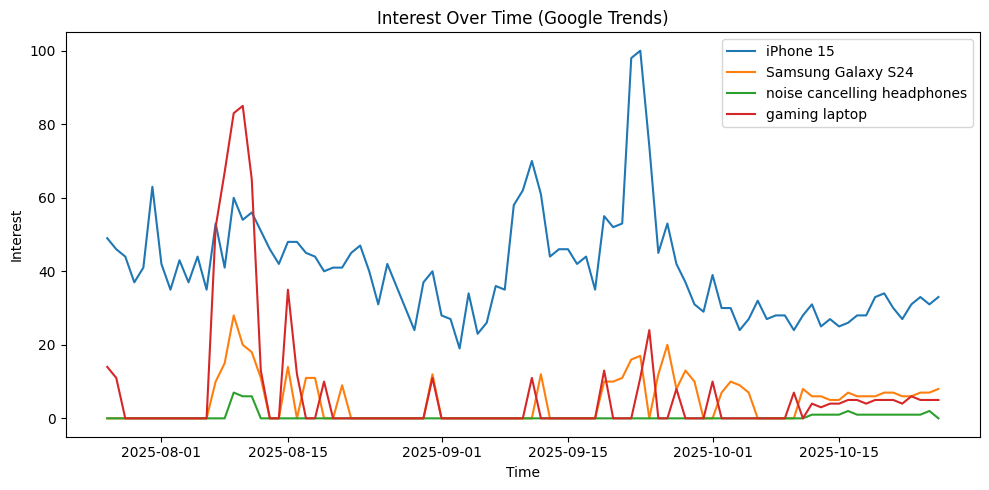

In [22]:
plt.figure(figsize=(10,5))
for kw in KEYWORDS:
    if kw in iot_df.columns:
        plt.plot(iot_df.index, iot_df[kw], label=kw)
plt.title("Interest Over Time (Google Trends)")
plt.xlabel("Time")
plt.ylabel("Interest")
plt.legend()
plt.tight_layout()
plt.show()

## 5) Related Queries – Discovery & Long‑Tail Signals

In [24]:
def fetch_related_queries(keywords, geo, timeframe, gprop):
    if MOCK or pytrend is None:
        return _mock_related_queries(keywords)
    pytrend.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo, gprop=gprop)
    return pytrend.related_queries()

rq = fetch_related_queries(KEYWORDS, GEO, TIMEFRAME, GPROP)

# Flatten top related queries
rows = []
for kw, parts in rq.items():
    top_df = parts.get("top")
    if isinstance(top_df, pd.DataFrame):
        for _, r in top_df.iterrows():
            rows.append({"keyword": kw, "query": r["query"], "value": int(r["value"])})
rq_top_df = pd.DataFrame(rows).sort_values(["keyword", "value"], ascending=[True, False]).reset_index(drop=True)
display(rq_top_df.head(20))

# Save artifact
rq_path = ARTIFACT_DIR / f"related_queries_top_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
rq_top_df.to_csv(rq_path, index=False)
print(f"Saved -> {rq_path}")

,keyword,query,value
0,Samsung Galaxy S24,samsung s24 ultra,100
1,Samsung Galaxy S24,samsung galaxy s24 ultra,100
2,Samsung Galaxy S24,samsung galaxy s24 5g,33
3,Samsung Galaxy S24,samsung galaxy s24 fe,31
4,Samsung Galaxy S24,samsung s24 fe,30
5,Samsung Galaxy S24,samsung galaxy s24 price,26
6,Samsung Galaxy S24,samsung s24 ultra price,20
7,Samsung Galaxy S24,samsung galaxy s24 ultra price,19
8,Samsung Galaxy S24,samsung galaxy s24 ultra 5g,16
9,Samsung Galaxy S24,iphone,15


Saved -> artifacts/related_queries_top_20251026_1309.csv


## 6) Realtime Trending Searches (India)

In [25]:
def fetch_realtime_trends(cat="all", geo="IN"):
    if MOCK or pytrend is None:
        return _mock_realtime_trends()
    # pytrends has realtime_trending_searches that requires a 'pn' like 'IN'
    # Note: Some endpoints may change over time; validate pytrends version.
    try:
        df = pytrend.realtime_trending_searches(pn=geo)  # country code like 'IN'
    except Exception as e:
        print("Realtime trends not available via current pytrends build:", e)
        return pd.DataFrame()
    return df

rt_df = fetch_realtime_trends(geo="IN")
display(rt_df.head(10))

rt_path = ARTIFACT_DIR / f"realtime_trends_IN_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
rt_df.to_csv(rt_path, index=False)
print(f"Saved -> {rt_path}")

Realtime trends not available via current pytrends build: The request failed: Google returned a response with code 404


""


Saved -> artifacts/realtime_trends_IN_20251026_1309.csv


## 7) City Targeting Proxy (Surat via Gujarat – `geo='IN-GJ'`)

In [26]:
def fetch_state_interest(keywords, sub_geo, timeframe, gprop):
    if MOCK or pytrend is None:
        df = _mock_interest_over_time(keywords, periods=7*24, freq='H')
        df["isPartial"] = False
        return df
    pytrend.build_payload(kw_list=keywords, timeframe=timeframe, geo=sub_geo, gprop=gprop)
    df = pytrend.interest_over_time()
    return df

state_df = fetch_state_interest(KEYWORDS, SUB_GEO, TIMEFRAME, GPROP)
display(state_df.tail())

state_path = ARTIFACT_DIR / f"interest_over_time_{SUB_GEO}_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
state_df.to_csv(state_path)
print(f"Saved -> {state_path}")

/home/zadmin/Desktop/genai-capstone/genaicapstone/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,iPhone 15,Samsung Galaxy S24,noise cancelling headphones,gaming laptop,isPartial
date,,,,,
2025-10-22,18,0,0,0,False
2025-10-23,17,4,0,0,False
2025-10-24,18,0,0,0,False
2025-10-25,13,4,0,0,False
2025-10-26,22,0,0,0,True


Saved -> artifacts/interest_over_time_IN-GJ_20251026_1309.csv


## 8) Package Signals for Downstream Agents (JSON Schema)

In [29]:
def package_signals(iot_df, state_df, rq_top_df, city_hint="Surat", state_code="IN-GJ"):
    def top_keyword(df, window=-48):
        # rank by mean interest over last 'window' rows
        sub = df.iloc[window:] if len(df) + window > 0 else df
        means = sub.drop(columns=[c for c in sub.columns if c == "isPartial"], errors="ignore").mean().sort_values(ascending=False)
        return [{"keyword": k, "score": float(v)} for k, v in means.items()]

    payload = {
        "as_of": datetime.utcnow().isoformat() + "Z",
        "market": {
            "country": "IN",
            "state": state_code,
            "city_proxy": city_hint
        },
        "signals": {
            "interest_over_time_national": top_keyword(iot_df),
            "interest_over_time_state": top_keyword(state_df),
            "related_queries_top": rq_top_df.head(50).to_dict(orient="records")
        }
    }
    return payload

signals = package_signals(iot_df, state_df, rq_top_df, city_hint="Surat", state_code=SUB_GEO)

json_path = ARTIFACT_DIR / f"market_signals_surats_proxy_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
with open(json_path, "w") as f:
    json.dump(signals, f, indent=2)

signals, json_path

/tmp/ipykernel_6304/1360048452.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "as_of": datetime.utcnow().isoformat() + "Z",


({'as_of': '2025-10-26T08:08:36.654885Z',
  'market': {'country': 'IN', 'state': 'IN-GJ', 'city_proxy': 'Surat'},
  'signals': {'interest_over_time_national': [{'keyword': 'iPhone 15',
     'score': 40.333333333333336},
    {'keyword': 'Samsung Galaxy S24', 'score': 5.729166666666667},
    {'keyword': 'gaming laptop', 'score': 3.1875},
    {'keyword': 'noise cancelling headphones', 'score': 0.3333333333333333}],
   'interest_over_time_state': [{'keyword': 'iPhone 15',
     'score': 6.145833333333333},
    {'keyword': 'Samsung Galaxy S24', 'score': 0.9375},
    {'keyword': 'gaming laptop', 'score': 0.125},
    {'keyword': 'noise cancelling headphones', 'score': 0.0}],
   'related_queries_top': [{'keyword': 'Samsung Galaxy S24',
     'query': 'samsung s24 ultra',
     'value': 100},
    {'keyword': 'Samsung Galaxy S24',
     'query': 'samsung galaxy s24 ultra',
     'value': 100},
    {'keyword': 'Samsung Galaxy S24',
     'query': 'samsung galaxy s24 5g',
     'value': 33},
    {'keywor

## 9) Agent Handoff – Example Function (for LangGraph/ADK)

In [28]:
def run_market_analyst(
    keywords=KEYWORDS,
    geo=GEO,
    sub_geo=SUB_GEO,
    timeframe=TIMEFRAME,
    gprop=GPROP,
    mock=MOCK
):
    global MOCK
    MOCK = mock
    global pytrend
    pytrend = make_trends_client()

    iot_df = fetch_interest_over_time(keywords, geo, timeframe, gprop)
    state_df = fetch_state_interest(keywords, sub_geo, timeframe, gprop)
    rq = fetch_related_queries(keywords, geo, timeframe, gprop)

    # flatten related queries
    rows = []
    for kw, parts in rq.items():
        top_df = parts.get("top")
        if isinstance(top_df, pd.DataFrame):
            for _, r in top_df.iterrows():
                rows.append({"keyword": kw, "query": r["query"], "value": int(r["value"])})
    rq_top_df = pd.DataFrame(rows).sort_values(["keyword", "value"], ascending=[True, False]).reset_index(drop=True)

    payload = package_signals(iot_df, state_df, rq_top_df, city_hint="Surat", state_code=sub_geo)

    return {
        "payload": payload,
        "artifacts": {
            "interest_over_time_csv": str((ARTIFACT_DIR / "interest_over_time_latest.csv").resolve()),
            "state_interest_over_time_csv": str((ARTIFACT_DIR / f"interest_over_time_{sub_geo}_latest.csv").resolve())
        }
    }

# Example dry run (mock)
out = run_market_analyst(mock=False)
out["payload"]

/home/zadmin/Desktop/genai-capstone/genaicapstone/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/home/zadmin/Desktop/genai-capstone/genaicapstone/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/tmp/ipykernel_6304/3105988233.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.date

{'as_of': '2025-10-26T07:40:02.130554Z',
 'market': {'country': 'IN', 'state': 'IN-GJ', 'city_proxy': 'Surat'},
 'signals': {'interest_over_time_national': [{'keyword': 'iPhone 15',
    'score': 40.45161290322581},
   {'keyword': 'gaming laptop', 'score': 6.56989247311828},
   {'keyword': 'Samsung Galaxy S24', 'score': 4.666666666666667},
   {'keyword': 'noise cancelling headphones', 'score': 0.3763440860215054}],
  'interest_over_time_state': [{'keyword': 'iPhone 15',
    'score': 4.774193548387097},
   {'keyword': 'gaming laptop', 'score': 2.053763440860215},
   {'keyword': 'Samsung Galaxy S24', 'score': 0.4838709677419355},
   {'keyword': 'noise cancelling headphones', 'score': 0.0}],
  'related_queries_top': [{'keyword': 'Samsung Galaxy S24',
    'query': 'samsung s24 ultra',
    'value': 100},
   {'keyword': 'Samsung Galaxy S24',
    'query': 'samsung galaxy s24 ultra',
    'value': 100},
   {'keyword': 'Samsung Galaxy S24',
    'query': 'samsung galaxy s24 5g',
    'value': 33},


## 10) Notes & Caveats
- City-level granularity in Google Trends is limited; we use **state-level (Gujarat: `IN-GJ`)** as a proxy for **Surat**.
- Use `GPROP='froogle'` to bias toward shopping intent (use `""` for overall web search).
- Real-time calls depend on Google Trends availability and the **pytrends** version. If `realtime_trending_searches` fails, use `trending_searches(pn='india')` as a fallback.
- Ensure this notebook runs in an environment with internet access if `MOCK=False`.
- For production, wrap `run_market_analyst` as a node/tool in your LangGraph/ADK graph and persist the JSON to cloud storage.